# Genre Prediction from Lyrics & Artist

This notebook performs genre classification using lyrics alone and also lyrics and artists. It includes data preprocessing, cleaning, analysis, and uses Bayesian Optimisation to tune hyperparameters via Keras Tuner.

In [33]:
"""
From https://colab.research.google.com/notebooks/pro.ipynb
"Making the Most of your Colab Subscription"

Used to confirm that Colab Pro GPU & memory is in use
"""

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Jan  3 13:37:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   50C    P0              28W /  72W |   1279MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [34]:
# Mount my Google drive to access the train and test files I uploaded

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [35]:
# Package installations
!pip install keras-tuner --upgrade
!pip install langid
!pip install imbalanced-learn

# Imports
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import langid
import pandas as pd
import re
import nltk
import tensorflow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.models import load_model

In [36]:
# Load training dataset
training_path = "/content/drive/MyDrive/Colab Notebooks/Lyrics/train.csv"

data = pd.read_csv(training_path)

# Show the first 5 rows to understand the format
data.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


## Check for missing values & remove as appropriate

In [37]:
print(data.isnull().sum())
print('\n',data.shape)

# Drop rows with missing Lyrics, Genre, or Artist
data = data.dropna(subset=['Lyrics', 'Genre', 'Artist'])
print(data.shape)

Artist       0
Song         1
Genre        0
Language     4
Lyrics      35
dtype: int64

 (290183, 5)
(290148, 5)


## Artist Distribution

Unique Artists: 11152


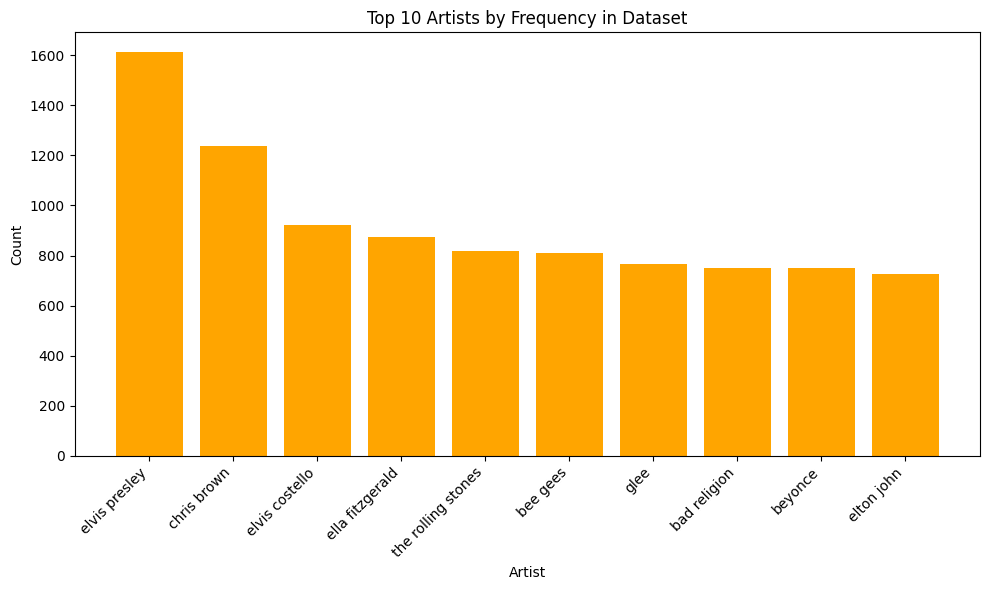

In [38]:
# Get the artist counts
artist_counts = data['Artist'].value_counts()

# Get number of unique artists
unique_artists = artist_counts.shape[0]

print(f"Unique Artists: {unique_artists}")

artist_distribution = pd.DataFrame({
    'Artist': artist_counts.index,
    'TOtal': artist_counts.values
})

#print("\nTop 10 Artists by Frequency:")
#print(artist_distribution.head(10))

# Plot the distribution for top 10 artists
top_artists = artist_distribution.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_artists['Artist'], top_artists['TOtal'], color='orange')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.title('Top 10 Artists by Frequency in Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

These numbers look suspiciously high for some artists. It's likely that they include a number of duplicates or lyrics from alternate song versions e.g. live versions, collaborations etc.
This may negatively impact the training process and resultant model.

For simplicity's sake, I will remove any rows with duplicate Artist & Song values.

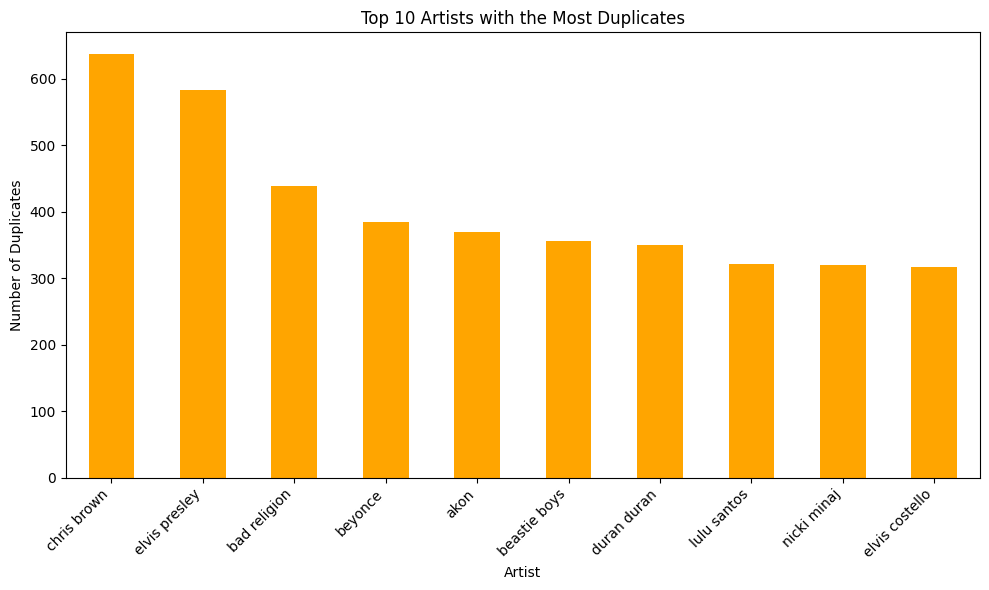

In [39]:
# Get the duplicated rows (artist & song)
duplicate_rows = data[data.duplicated(subset=['Artist', 'Song'], keep='first')]

# Get the number of duplicated rows per artist
artist_duplicates = duplicate_rows['Artist'].value_counts()

# Display the top artists with the most duplicates
#print("Artists with the most duplicates:")
#print(artist_duplicates.head(10))

# Plot the top 10 artists with the most duplicates
plt.figure(figsize=(10, 6))
artist_duplicates.head(10).plot(kind='bar', color='orange')
plt.xlabel('Artist')
plt.ylabel('Number of Duplicates')
plt.title('Top 10 Artists with the Most Duplicates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [40]:
# Actually remove the duplicated rows
data = data.drop_duplicates(subset=['Artist', 'Song'], keep='first')
print(f"Data shape after removing duplicates: {data.shape}")



Data shape after removing duplicates: (241980, 5)


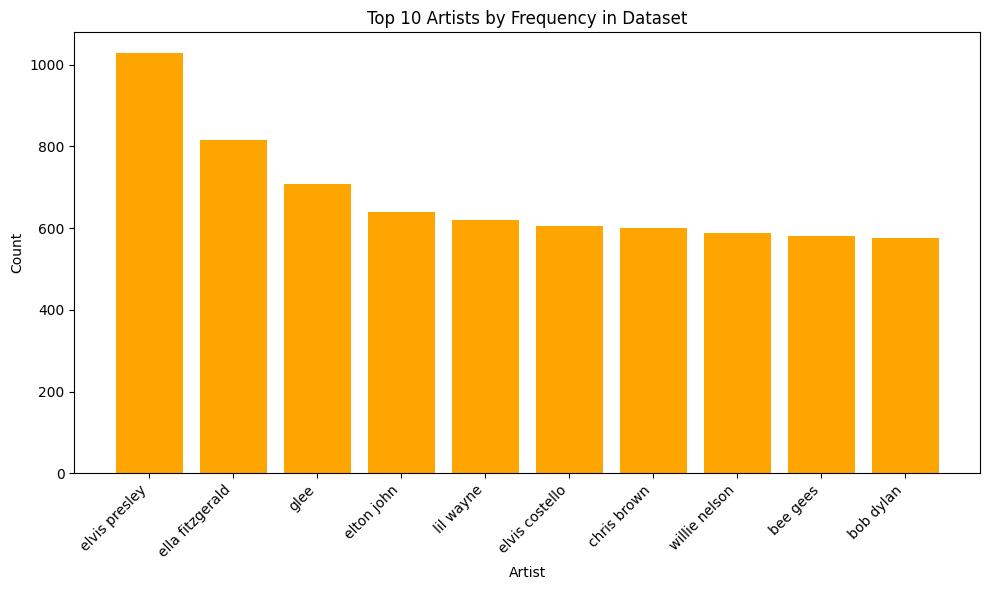

In [41]:
# Get the refreshed distribution of artists after duplicate removal
artist_counts = data['Artist'].value_counts()

artist_distribution = pd.DataFrame({
    'Artist': artist_counts.index,
    'Count': artist_counts.values
})

# Print the top 10 most common artists
#print("\nTop 10 Artists by Frequency:")
#print(artist_distribution.head(10))

# Plot the distribution for top 10 artists
top_artists = artist_distribution.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_artists['Artist'], top_artists['Count'], color='orange')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.title('Top 10 Artists by Frequency in Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Further analysis of artist distribution using binning for visualisation

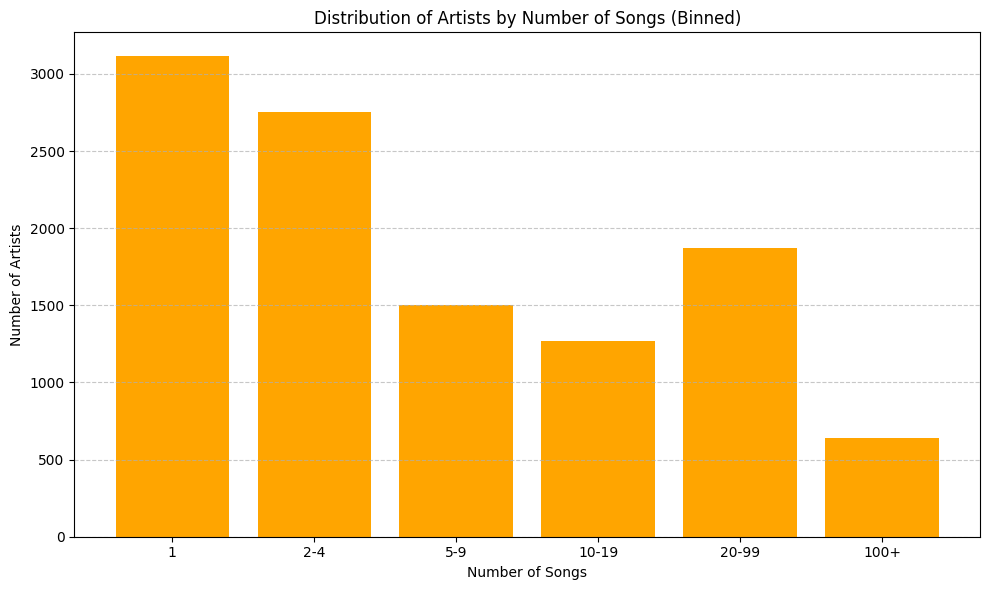

In [42]:
# Define the bins
bins = [1, 2, 5, 10, 20, 100, np.inf]
bin_labels = ['1', '2-4', '5-9', '10-19', '20-99', '100+']

binned_counts = pd.cut(artist_counts, bins=bins, labels=bin_labels, right=False)

# Count the number of artists in each bin
artist_bin_distribution = binned_counts.value_counts().sort_index()

bin_df = pd.DataFrame({
    'Songs': artist_bin_distribution.index,
    'Artists': artist_bin_distribution.values
})

#print("Binned Distribution of Artists by Number of Songs:")
#print(bin_df)

# Plot the binned distribution by artist
plt.figure(figsize=(10, 6))
plt.bar(bin_df['Songs'], bin_df['Artists'], color='orange')
plt.xlabel('Number of Songs')
plt.ylabel('Number of Artists')
plt.title('Distribution of Artists by Number of Songs (Binned)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# One-Hit Wonders
There are evidently a huge number of artists (>3000) who feature only once in the data set and a similar number who appear fewer than 10 times.
Meanwhile there are a much smaller number of artists (~600) who have more than 100 songs.
This skewed distribution suggests that any model relying on Artist is likely to suffer from overfitting. It may perform well for artists seen frequently in the training set but poorly for unseen artists.
Intuitively, this makes sense as generally artists tend to align with a single genre in music.

## Genre Encoding & Analysis

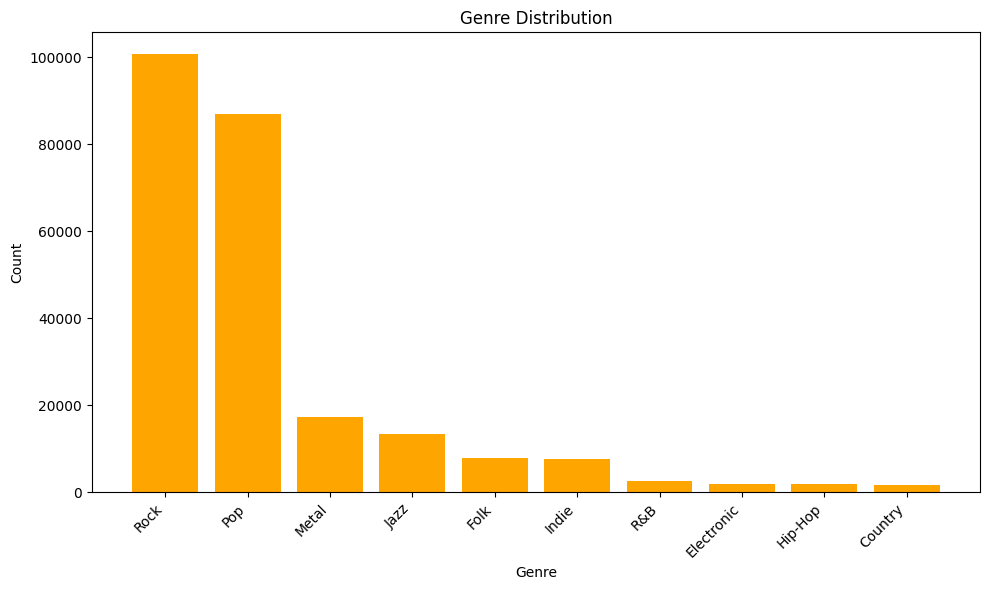

In [43]:
# Create a labelEncoder and replace the Genre column with the encoded indexes
genre_encoder = LabelEncoder()
old_column = data['Genre'] # To restore the old genre column in case I reran the next line :(
# Note: do not rerun this line or the original genre names will be lost
data['Genre'] = genre_encoder.fit_transform(data['Genre'])

genre_vals = data['Genre'].value_counts()

# Use an inverse transform to keep the old names for display later
genres = genre_encoder.inverse_transform(genre_vals.index)

genre_distro = pd.DataFrame({
    'Genre': genres,
    'Count': genre_vals.values
})

#print("Genre Distribution:")
#print(genre_distro)

plt.figure(figsize=(10, 6))
plt.bar(genre_distro['Genre'], genre_distro['Count'], color='orange')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Multi-Lingual Exploration (SLOW. OPTIONAL)
The data set is described as multi-lingual. I will use the **langid** library to attempt to automatically detect the language of the Lyrics column in each row and augment the table with a Language column.

                                              Lyrics Language
0  It starts with pain, followed by hate\nFueled ...       en
1  Freedom!\nAlone again again alone\nPatiently w...       en
2  Biting the hand that feeds you, lying to the v...       en
3  You say you know just who I am\nBut you can't ...       en
4  My heart is beating faster can't control these...       en

Language Distribution:
Language
en    211052
pt     23294
es      3306
it       696
fr       545
       ...  
cs         1
zh         1
sq         1
ja         1
az         1
Name: count, Length: 68, dtype: int64


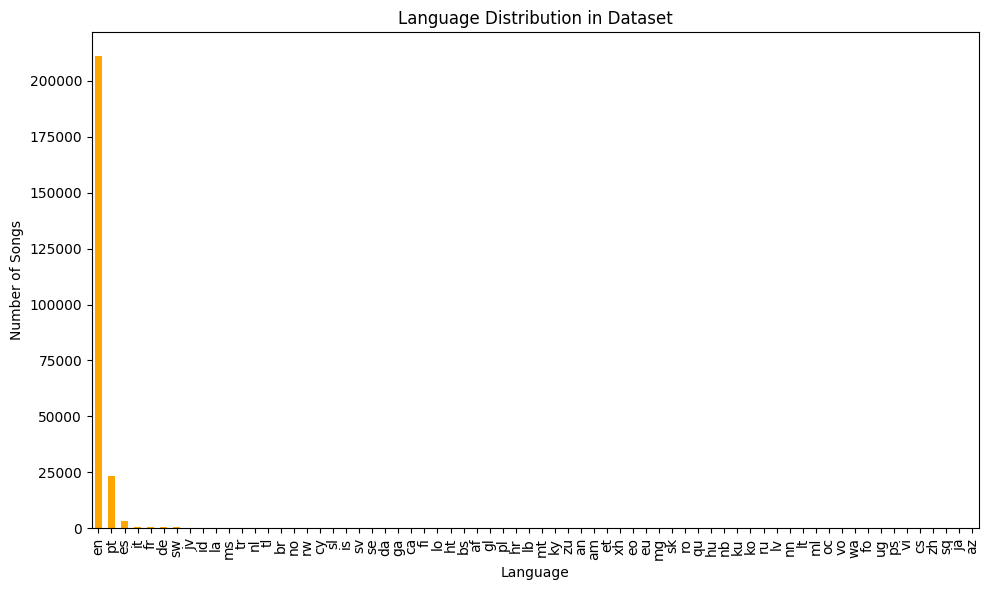

In [ ]:
def detect_language(text):
    lang, _ = langid.classify(text)  # langid returns a tuple (language, confidence)
    return lang

# Augment the table with a Language column
data['Language'] = data['Lyrics'].apply(detect_language)

# Display the first few rows with the new Language column
print(data[['Lyrics', 'Language']].head())

# Count the occurrences of each language
language_distribution = data['Language'].value_counts()
print("\nLanguage Distribution:")
print(language_distribution)

# Plot the language distribution
language_distribution.plot(kind='bar', figsize=(10, 6), color='orange')
plt.xlabel('Language')
plt.ylabel('Number of Songs')
plt.title('Language Distribution in Dataset')
plt.tight_layout()
plt.show()

In [ ]:
# Group the data by the 'Language' column and take the first row for each unique language
example_language = data.groupby('Language').first().reset_index()

print("One sample row per unique language:")
print(example_language[['Language', 'Lyrics', 'Song', 'Artist']])

One sample row per unique language:
   Language                                             Lyrics  \
0        af  Shortcut to part of Blondie Lyrics\nBlondie - ...   
1        am  VOCÊ TEM QUE OLHAR A ESTRADA\nCOM UMA CARA CAN...   
2        an  Tuned down a half step (Chords given in regula...   
3        az  Beqasam to'nlar kiyib, buncha mani kuydirasan\...   
4        br  Brother\nOoh-ooh\nShake it up, shake it up\nMo...   
..      ...                                                ...   
63       vo  Zip-A-Dee-Doo-Dah\nZip-A-Dee-A\nZip-A-Dee-Doo-...   
64       wa  Seu popô no meu pipi\nSeu pipi no meu popô\nMe...   
65       xh  Flying\nAnd you know I'm not coming down\nYou'...   
66       zh  Intro\ne--0----------------------------------\...   
67       zu  THEY DON'T KNOW\nTHEY DON'T KNOW\nLIKE I KNOW\...   

                                      Song                 Artist  
0                           diamond bridge                blondie  
1                              velh

I experimented with some models that used the new language column but a) the results were not particularly promising, b) the quality of the language inference was extremely suspect as seen in the results above, and c) the data set is so heavily skewed towards English that it's unlikely to have ever resulted in better training on non-English languages apart from Portuguese or Spanish.

It could have been used to apply a different set of "stop words" for the non-English lyrics.

In the end I chose to ignore the multi-lingual aspect given time constraints.

## Text Preprocessing for Lyrics

In [44]:
# Use standard English stop words that are probably just noise in terms of genre inference
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # strip out everything except letters. Some loss of data for Prince lyrics & title

    # Remove stop words
    text = ' '.join([w for w in text.split() if w not in stopWords])
    return text

data['Lyrics'] = data['Lyrics'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data set splitting & preparation

In [45]:
# TODO: refactor this sloppy section to be parameterised based on whether I'm using lyrics or lyrics & artist

# Split into train & test using standard 20% split
X_train_lyrics, X_test_lyrics, y_train_lyrics, y_test_lyrics = train_test_split(data['Lyrics'], data['Genre'], test_size=0.2, random_state=123)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(data[['Lyrics', 'Artist']], data['Genre'], test_size=0.2, random_state=123)

vocabularySize = 10000 # number of unique words model will use
tokeniser_lyrics = Tokenizer(num_words=vocabularySize, oov_token="<OOV>")
tokeniser_lyrics.fit_on_texts(X_train_lyrics)

tokeniser_both = Tokenizer(num_words=vocabularySize, oov_token="<OOV>")
tokeniser_both.fit_on_texts(X_train_both)

X_train_lyrics_sq = tokeniser_lyrics.texts_to_sequences(X_train_lyrics)
X_test_lyrics_sq = tokeniser_lyrics.texts_to_sequences(X_test_lyrics)

X_train_both_sq = tokeniser_both.texts_to_sequences(X_train_both)
X_test_both_sq = tokeniser_both.texts_to_sequences(X_test_both)

# Padding
first_n_words = 100 # only use first n tokens. Lossy. Consider as tuning parameter
X_train_lyrics_pad = pad_sequences(X_train_lyrics_sq, maxlen=first_n_words, padding='post')
X_test_lyrics_pad = pad_sequences(X_test_lyrics_sq, maxlen=first_n_words, padding='post')

X_train_both_pad = pad_sequences(X_train_both_sq, maxlen=first_n_words, padding='post')
X_test_both_pad = pad_sequences(X_test_both_sq, maxlen=first_n_words, padding='post')

# Confirm tokenisation & padding yields 100 words per row
print(f"Lyrics training shape: {X_train_lyrics_pad.shape}")
print(f"Lyrics testing shape: {X_test_lyrics_pad.shape}")

Lyrics training shape: (193584, 100)
Lyrics testing shape: (48396, 100)


# Genre imbalance
There's an obvious class imbalance where Rock & Pop are the dominant genres. I spent some time exploring options to address this imbalance before training.

I looked at SMOTE and under sampling but the resulting models were unsatisfactory.

I also experimented with a class weighting approach where the training data of the rarer genres would be given more weight but ran into technical issues trying to get this working when tuning and training.

The rebalancing is commented out but left in place for reference.

Also, there is some debate about whether these strategies are effective especially the likes of SMOTE which "create training data". The genre imbalance may actually be somewhat representative of real world genre imbalance in popular song and so it may actually be ok to leave it as is.

In [ ]:
"""
smote = SMOTE(random_state=123)

# Apply SMOTE
X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train_pad, y_train)

print("Distribution after SMOTE:")
print(Counter(y_train_upsampled))"""

'\nsmote = SMOTE(random_state=123)\n\n# Apply SMOTE\nX_train_upsampled, y_train_upsampled = smote.fit_resample(X_train_pad, y_train)\n\nprint("Distribution after SMOTE:")\nprint(Counter(y_train_upsampled))'

In [ ]:
"""
undersampler = RandomUnderSampler(random_state=123)

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_pad, y_train)

print("Distribution after under sampling:", Counter(y_train_resampled))"""

'\nundersampler = RandomUnderSampler(random_state=123)\n\nX_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_pad, y_train)\n\nprint("Distribution after under sampling:", Counter(y_train_resampled))'

## Hyperparameter Tuning

In [46]:
# Reusable model builder
def build_model(params):
    model = Sequential()

    # Tuning of embedding dimensions
    model.add(
        Embedding(
            input_dim=vocabularySize,
            output_dim=params.Int('embedding_dim', min_value=32, max_value=128, step=32)
        )
    )

    # Tuning of RNN type - assignment requires comparison of RNN & LSTM & also multi layer LSTM
    rnn_type = params.Choice('rnn_type', ['RNN', 'LSTM', '3-LSTM'])

    # Tuning of units
    rnn_units = params.Int('rnn_units', min_value=32, max_value=128, step=32)

    # After picking a variant, add the model(s) with selected units
    if rnn_type == 'LSTM':
        model.add(LSTM(rnn_units))
    elif rnn_type == '3-LSTM':
        model.add(LSTM(rnn_units, return_sequences=True)) # add stacked layer
        model.add(LSTM(rnn_units, return_sequences=True)) # add stacked layer
        model.add(LSTM(rnn_units))
    else:
        model.add(SimpleRNN(rnn_units))

    # Output layer
    model.add(Dense(len(genre_encoder.classes_), activation='softmax')) # using softmax because of muliple classes

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [47]:

# Using Bayesian hyper param tuning to try and maximise my Colab Pro GPU time
tuner_lyrics = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    max_consecutive_failed_trials=3,
    executions_per_trial=1,
    directory='tuning_lyrics',
    project_name='genre_from_lyrics',
    overwrite=True
)

tuner_both = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    max_consecutive_failed_trials=3,
    executions_per_trial=1,
    directory='tuning_both',
    project_name='genre_from_both',
    overwrite=True
)

# Perform tuning
tuner_lyrics.search(X_train_lyrics_pad, y_train_lyrics, validation_split=0.2, epochs=5, batch_size=32)
tuner_both.search(X_train_both_pad, y_train_both, validation_split=0.2, epochs=5, batch_size=32)

# Get the top 2 HP params & model for each approach (lyrics or both)
best_lyrics_params = tuner_lyrics.get_best_hyperparameters(num_trials=2)
lyrics_hps1 = best_lyrics_params[0]
lyric_hps2 = best_lyrics_params[1]

best_both_params = tuner_both.get_best_hyperparameters(num_trials=2)
both_hps1 = best_both_params[0]
both_hps2 = best_both_params[1]

print(f"Best Hyperparameters (Lyrics): {lyrics_hps1.values}")
print(f"Best Hyperparameters (Lyrics & Artist): {both_hps1.values}")

best_models_lyrics = tuner_lyrics.get_best_models(num_models=2)
lyrics_model1 = best_models_lyrics[0]
lyrics_model2 = best_models_lyrics[1]

best_models_both = tuner_both.get_best_models(num_models=2)
both_model1 = best_models_both[0]
both_model2 = best_models_both[1]

Trial 10 Complete [00h 00m 05s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 43s
Best Hyperparameters (Lyrics): {'embedding_dim': 96, 'rnn_type': '3-LSTM', 'rnn_units': 96}
Best Hyperparameters (Lyrics & Artist): {'embedding_dim': 96, 'rnn_type': 'LSTM', 'rnn_units': 64}


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [48]:
# Save the models
lyrics_model1.save('lyrics_model1.keras')
lyrics_model2.save('lyrics_model2.keras')
both_model1.save('both_model1.keras')
both_model2.save('both_model2.keras')

## Train the Best Models

Epoch 1/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 86s 17ms/step - accuracy: 0.6516 - loss: 1.0418 - val_accuracy: 0.6070 - val_loss: 1.1437
Epoch 2/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.6690 - loss: 0.9930 - val_accuracy: 0.6062 - val_loss: 1.1571
Epoch 3/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.6877 - loss: 0.9440 - val_accuracy: 0.6026 - val_loss: 1.1947
Epoch 4/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.7107 - loss: 0.8812 - val_accuracy: 0.5979 - val_loss: 1.2146
Epoch 5/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.7279 - loss: 0.8253 - val_accuracy: 0.5899 - val_loss: 1.2871
Epoch 6/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.7490 - loss: 0.7681 - val_accuracy: 0.5854 - val_loss: 1.3294
Epoch 7/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.7678 - loss: 0.7100 - val_accuracy: 0.5859 - val_loss: 1.3588
Epoch 8/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.7860 -

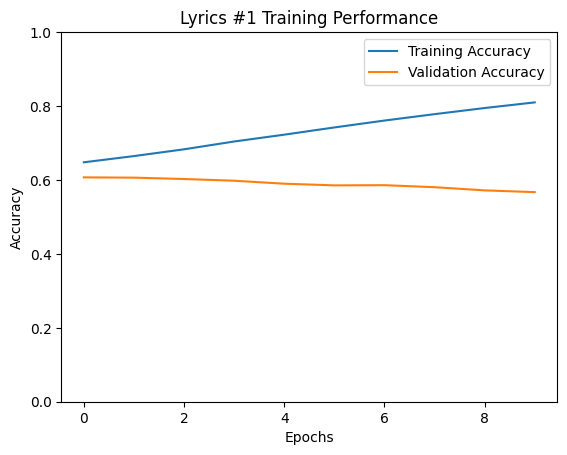

Lyrics #1 Test Loss: 1.5754743814468384
Lyrics #1 Test Accuracy: 0.5750475525856018
Epoch 1/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.6564 - loss: 1.0228 - val_accuracy: 0.6073 - val_loss: 1.1532
Epoch 2/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - accuracy: 0.6758 - loss: 0.9703 - val_accuracy: 0.6055 - val_loss: 1.1577
Epoch 3/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - accuracy: 0.6944 - loss: 0.9238 - val_accuracy: 0.6023 - val_loss: 1.2075
Epoch 4/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - accuracy: 0.7172 - loss: 0.8633 - val_accuracy: 0.5978 - val_loss: 1.2317
Epoch 5/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - accuracy: 0.7317 - loss: 0.8137 - val_accuracy: 0.5947 - val_loss: 1.2840
Epoch 6/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - accuracy: 0.7505 - loss: 0.7568 - val_accuracy: 0.5924 - val_loss: 1.3128
Epoch 7/10
4840/4840 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - accuracy: 0.7683 - loss: 0.7049 - val_accuracy: 0.5800 - val_loss:

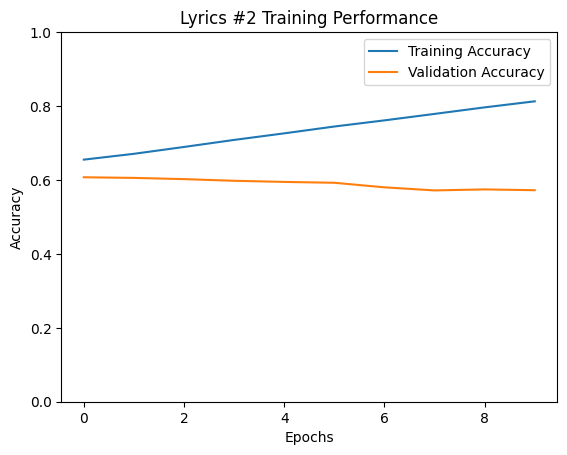

Lyrics #2 Test Loss: 1.6460851430892944
Lyrics #2 Test Accuracy: 0.572464644908905


In [49]:
# print(class_weight_dict) - abandoned effort at class weighting for genre imbalance

# Plot metrics
def plot_metrics(history, title):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title(title)
    plt.legend()
    plt.show()

history = lyrics_model1.fit(X_train_lyrics_pad, y_train_lyrics, validation_split=0.2, epochs=10, batch_size=32)
loss, accuracy = lyrics_model1.evaluate(X_test_lyrics_pad, y_test_lyrics, batch_size=32)
plot_metrics(history, "Lyrics #1 Training Performance")
print(f"Lyrics #1 Test Loss: {loss}")
print(f"Lyrics #1 Test Accuracy: {accuracy}")

history = lyrics_model2.fit(X_train_lyrics_pad, y_train_lyrics, validation_split=0.2, epochs=10, batch_size=32)
loss, accuracy = lyrics_model2.evaluate(X_test_lyrics_pad, y_test_lyrics, batch_size=32)
plot_metrics(history, "Lyrics #2 Training Performance")
print(f"Lyrics #2 Test Loss: {loss}")
print(f"Lyrics #2 Test Accuracy: {accuracy}")



In [50]:
print(f"Best Hyperparameters (Lyrics): {lyrics_hps1.values}")
print(f"Second best Hyperparameters (Lyrics): {lyric_hps2.values}")


Best Hyperparameters (Lyrics): {'embedding_dim': 96, 'rnn_type': '3-LSTM', 'rnn_units': 96}
Second best Hyperparameters (Lyrics): {'embedding_dim': 64, 'rnn_type': '3-LSTM', 'rnn_units': 128}


In [ ]:
"""history = both_model1.fit(X_train_both_pad, y_train_both, validation_split=0.2, epochs=10, batch_size=32)
loss, accuracy = both_model1.evaluate(X_test_both_pad, y_test_both, batch_size=32)
plot_metrics(history, "Lyrics & Artist #1 Training Performance")
print(f"Lyrics & Artist #1 Test Loss: {loss}")
print(f"Lyrics & Artist #1 Test Accuracy: {accuracy}")

history = both_model2.fit(X_train_both_pad, y_train_both, validation_split=0.2, epochs=10, batch_size=32)
#loss, accuracy = both_model2.evaluate(X_test_both_pad, y_test_both, batch_size=32)
plot_metrics(history, "Lyrics & Artist #2 Training Performance")
print(f"Lyrics & Artist #2 Test Loss: {loss}")
print(f"Lyrics & Artist #2 Test Accuracy: {accuracy}")"""

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 3.9439e-04 - val_accuracy: 1.0000 - val_loss: 3.7329e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 3.7329e-04 - val_accuracy: 1.0000 - val_loss: 3.5470e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 3.5470e-04 - val_accuracy: 1.0000 - val_loss: 3.3802e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 3.3802e-04 - val_accuracy: 1.0000 - val_loss: 3.2324e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 3.2324e-04 - val_accuracy: 1.0000 - val_loss: 3.1025e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 3.1025e-04 - val_accuracy: 1.0000 - val_loss: 2.9857e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 2.9857e-04 - val_accuracy: 1.0000 - val_loss: 2.8833e-04
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 -

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 2
'y' sizes: 48396


## Save the Best Models (based on above results)

In [51]:
# Save the best models
lyrics_model1.save('/content/drive/My Drive/lyrics_model1.keras')
lyrics_model2.save('/content/drive/My Drive/lyrics_model2.keras')


In [52]:
# Load  and tidy up the test dataset using similar steps to those used for training. Should have made this into a function really
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Lyrics/test.csv"
test_data = pd.read_csv(test_dataset_path)

print(test_data.isnull().sum())
test_data = test_data.dropna(subset=['Lyrics', 'Genre', 'Artist'])
test_data['Lyrics'] = test_data['Lyrics'].apply(preprocess)

X_test_sq = tokeniser_lyrics.texts_to_sequences(test_data['Lyrics'])
X_test_padded = pad_sequences(X_test_sq, maxlen=first_n_words, padding='post')

y_test = genre_encoder.transform(test_data['Genre'])

# Convert data to correct types - eventually figured out this was causing model evaluation to fail
X_test_padded = np.array(X_test_padded, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

Song         0
Song year    0
Artist       0
Genre        0
Lyrics       0
Track_id     0
dtype: int64


In [53]:
# Load the best model
best_model = lyrics_model1
best_model.summary()

print(best_model.loss)

# Evaluate the model on test data
loss, accuracy = best_model.evaluate(X_test_padded, y_test, batch_size=2)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 96)             │         960,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 96)             │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 96)             │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 96)                  │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,549,920 (13.54 MB)

 Trainable params: 1,183,306 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,366,614 (9.03 MB)

sparse_categorical_crossentropy
3968/3968 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.2930 - loss: 3.4685
Test Loss: 3.4914021492004395
Test Accuracy: 0.2917454242706299


In [54]:
# Load the 2nd best model
best_model = lyrics_model2
best_model.summary()

print(best_model.loss)

# Evaluate the model on test data
loss, accuracy = best_model.evaluate(X_test_padded, y_test, batch_size=2)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,009,824 (11.48 MB)

 Trainable params: 1,003,274 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,006,550 (7.65 MB)

sparse_categorical_crossentropy
3968/3968 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.2912 - loss: 3.5794
Test Loss: 3.5906577110290527
Test Accuracy: 0.28872084617614746


# Test Results
The accuracy results for both of my "best" models were under 30% which is far below the accuracy seen in the training splits earlier.

I suspect there is something fundamentally different in the makeup of the training and test data.

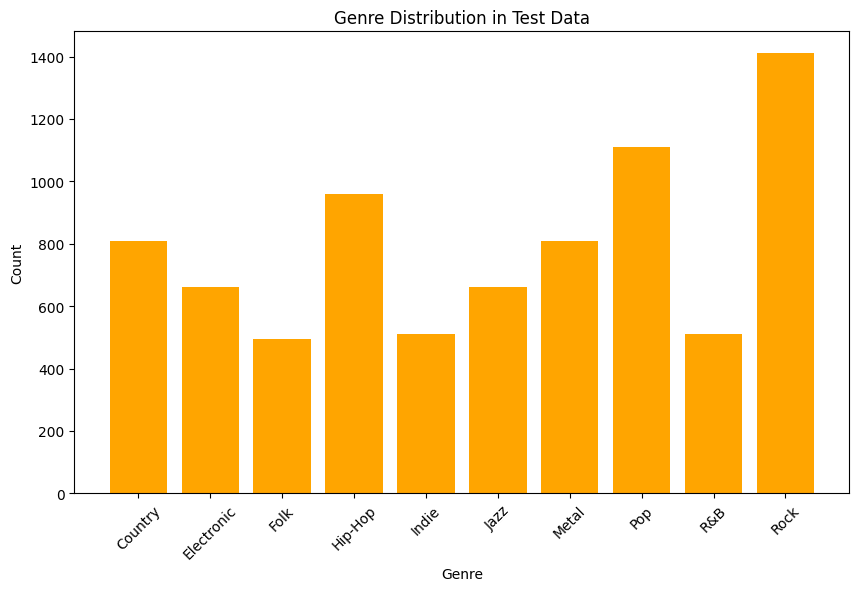

In [55]:
unique, counts = np.unique(y_test, return_counts=True)

# Use genre_encoder to get the genre names
genre_names = genre_encoder.inverse_transform(unique)

plt.figure(figsize=(10, 6))
plt.bar(genre_names, counts, color='orange')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution in Test Data')
plt.xticks(rotation=45)
plt.show()


# Genre distribution
The distribution in the test data is significantly different from that seen in the training data. The poor performance of my model on unseen test data with a different genre distribution is indicative of overfitting.

Even though the training results were poorer, it may have been better in the end to have followed through on the use of undersampling or some other method to compensate for the observed class imbalance.

# Export for demo

In [59]:
# pickle demo data, models etc.
from google.colab import files
import pickle

to_save = {
    "X_test_padded": X_test_padded,
    "artist_distribution": artist_distribution,
    "bin_df": bin_df,
    "genre_distro": genre_distro,
    "genre_encoder": genre_encoder,
}

with open('lyricsA.pkl', 'wb') as f:
    pickle.dump(to_save, f)

to_save = {
    "lyrics_model1": lyrics_model1,
    #"lyrics_model2": lyrics_model2,
    #"y_test": y_test,
    #"tokeniser_lyrics": tokeniser_lyrics
}

with open('lyricsB.pkl', 'wb') as f:
    pickle.dump(to_save, f)

to_save = {
    #"lyrics_model1": lyrics_model1,
    "lyrics_model2": lyrics_model2,
    #"y_test": y_test,
    #"tokeniser_lyrics": tokeniser_lyrics
}

with open('lyricsC.pkl', 'wb') as f:
    pickle.dump(to_save, f)

to_save = {
    #"lyrics_model1": lyrics_model1,
    #"lyrics_model2": lyrics_model2,
    "y_test": y_test,
    "tokeniser_lyrics": tokeniser_lyrics
}

with open('lyricsD.pkl', 'wb') as f:
    pickle.dump(to_save, f)

# Download the file
files.download("lyricsA.pkl")
files.download("lyricsB.pkl")
files.download("lyricsC.pkl")
files.download("lyricsD.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>